In [6]:
import sys
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin

from importlib import reload

sys.path.append('../')
import waveform_processing as proc
reload(proc)

<module 'waveform_processing' from '../waveform_processing.py'>

In [7]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

## Load data and define a few functions

In [10]:
APD = np.loadtxt('./Wave8_waveforms_APD.csv', delimiter=',')
diode = np.loadtxt('./Wave8_waveforms_diode.csv', delimiter=',')

def removeBackground(signal, ave_window=[0,500]):
    """
    Set the baseline of the waveform to 0
    """
    if signal.ndim ==1:
        return signal - np.median(signal[ave_window[0]:ave_window[1]])
    elif signal.ndim==2:
        med = np.median(signal[:,ave_window[0]:ave_window[1]], axis=1)  
        return signal - med.reshape(med.shape[0],1)

## Preprocessing

In [11]:
APD = removeBackground(APD, ave_window=[0,30])
diode = removeBackground(diode, ave_window=[0,30])

## Plot a bunch of traces

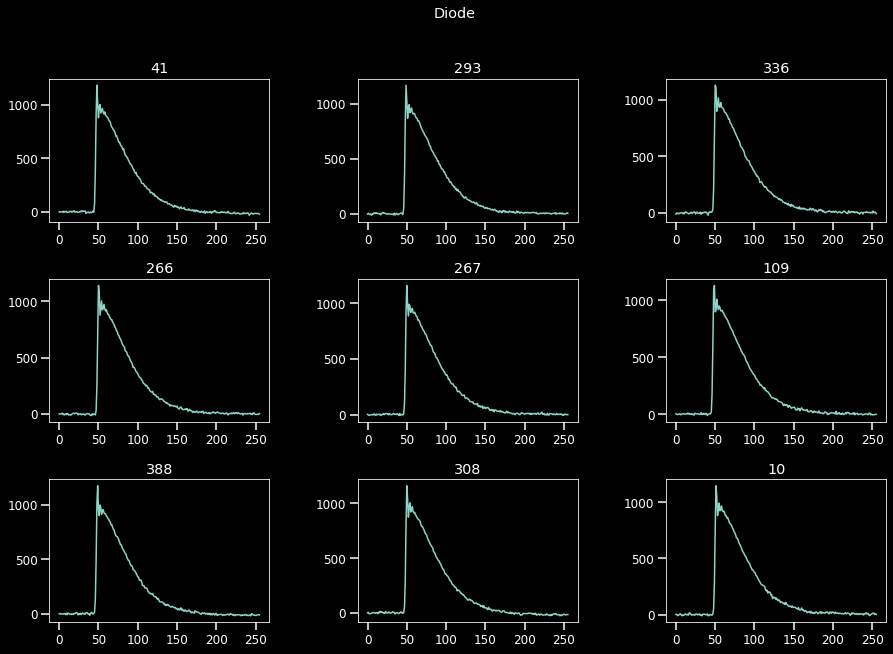

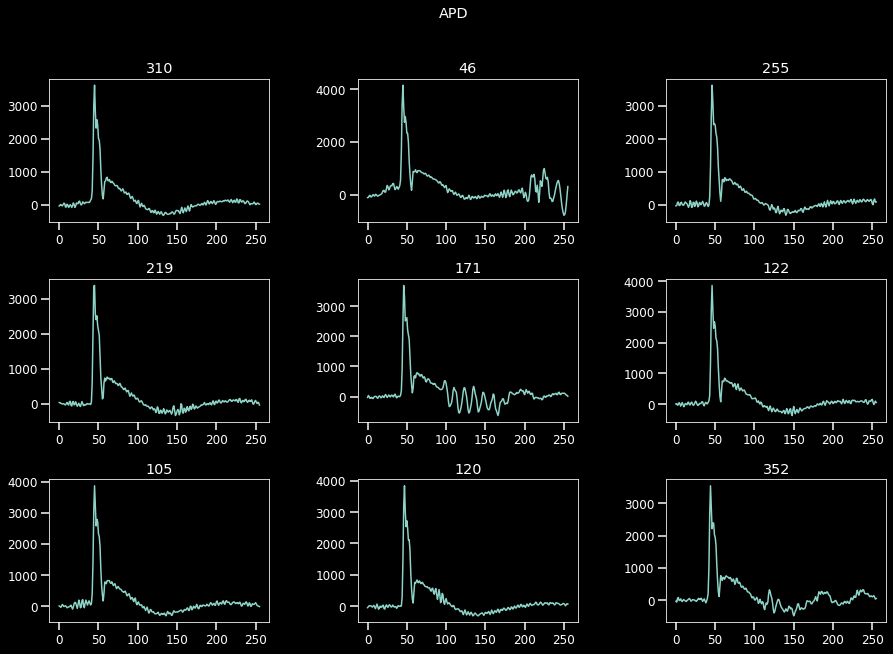

In [12]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Diode')
for ii in range(9):
    idx = np.random.randint(diode.shape[0])
    ax = fig.add_subplot(3,3,ii+1)
    ax.set_title(str(idx))
    ax.plot(diode[idx])

# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()
print('\n\n')

fig = plt.figure(figsize=(15,10))
fig.suptitle('APD')
for ii in range(9):
    idx = np.random.randint(APD.shape[0])
    ax = fig.add_subplot(3,3,ii+1)
    ax.set_title(str(idx))
    ax.plot(APD[idx])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

# Analyze diode

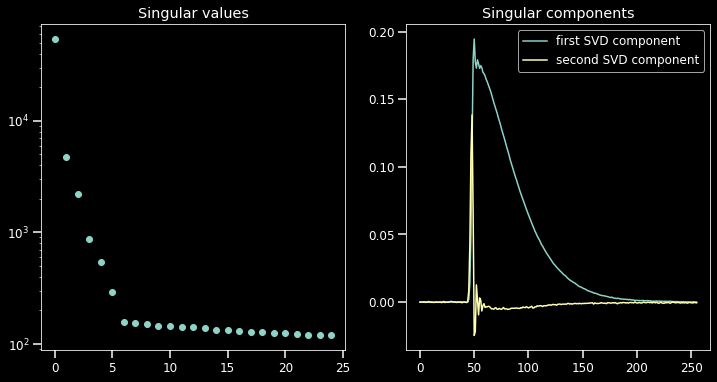

In [13]:
A, proj, svd = proc.get_basis_and_projector(diode[:100], n_components=1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(svd.singular_values_,'o')
plt.yscale('log')
plt.title('Singular values')

plt.subplot(1,2,2)
plt.plot(svd.components_[0], label='first SVD component')
plt.plot(svd.components_[1]*0.2, label='second SVD component')
# plt.plot(svd.components_[3], 'r', label='third SVD component')
plt.title('Singular components')
plt.legend()
plt.show()

In [14]:
diode_regressor = proc.construct_waveformRegressor(diode[:100])

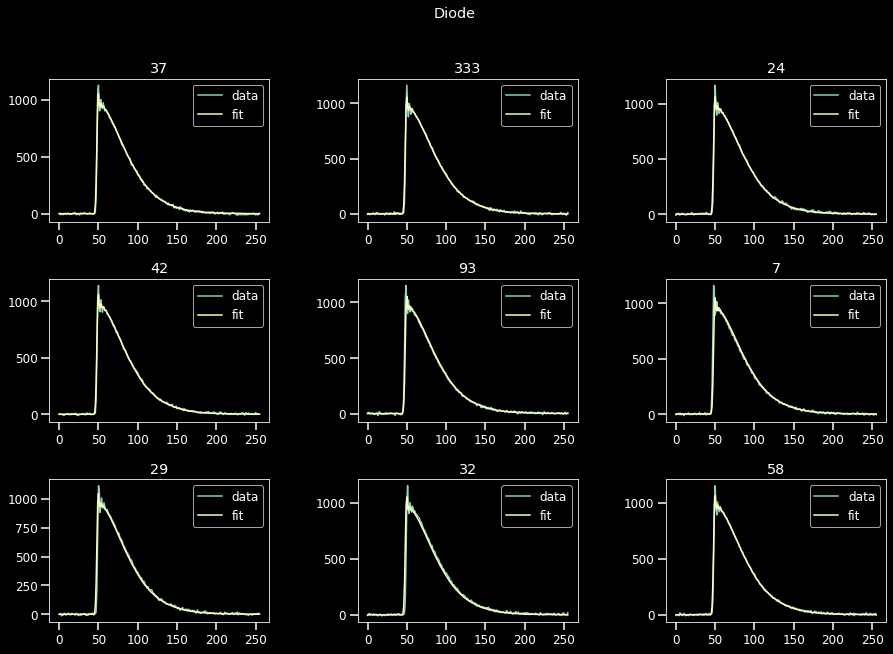

In [15]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Diode')
for ii in range(9):
    idx = np.random.randint(diode.shape[0])
    ax = fig.add_subplot(3,3,ii+1)
    ax.set_title(str(idx))
    ax.plot(diode[idx], label='data')
    ax.plot(diode_regressor.fit_reconstruct(diode[idx]), label='fit')
    ax.legend()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

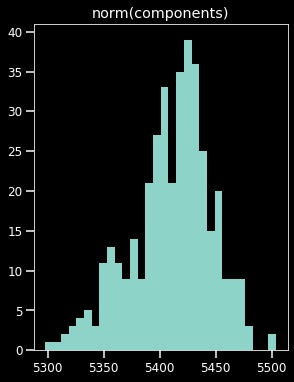

Thorlabs diode standard deviation/mean: 0.0066167437369420825


In [39]:
intensity = np.squeeze(diode_regressor.get_pulse_intensity(diode))
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('norm(components)')
plt.hist(intensity, bins=30)
# plt.subplot(1,2,2)
# plt.title('max(fit)')
# plt.hist(intensity[:,1], bins=30)
plt.show()

average = np.mean(intensity)
sigma = np.std(intensity)
print('Thorlabs diode standard deviation/mean:',sigma/average)

### Score

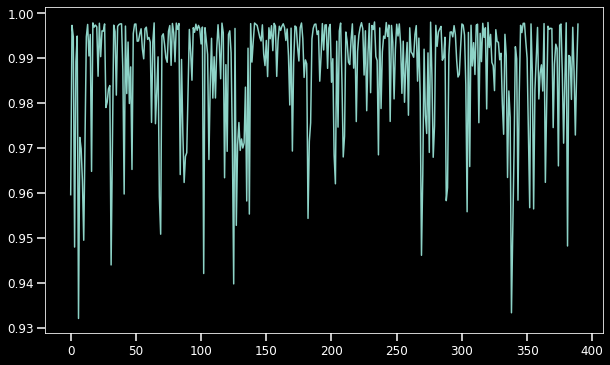

In [28]:
score = []
for d in diode:
    diode_regressor.fit(d)
    diode_regressor.fit(d)
    score.append(diode_regressor.score(d))
plt.plot(score)
plt.show()

# APD analysis

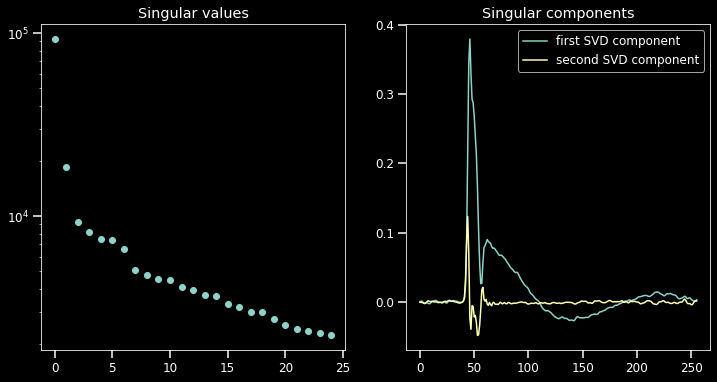

In [29]:
A, proj, svd = proc.get_basis_and_projector(APD[:100], n_components=1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(svd.singular_values_,'o')
plt.yscale('log')
plt.title('Singular values')

plt.subplot(1,2,2)
plt.plot(svd.components_[0], label='first SVD component')
plt.plot(svd.components_[1]*0.2, label='second SVD component')
# plt.plot(svd.components_[3], 'r', label='third SVD component')
plt.title('Singular components')
plt.legend()
plt.show()

In [30]:
APD_regressor = proc.construct_waveformRegressor(APD[:100], n_components=1)

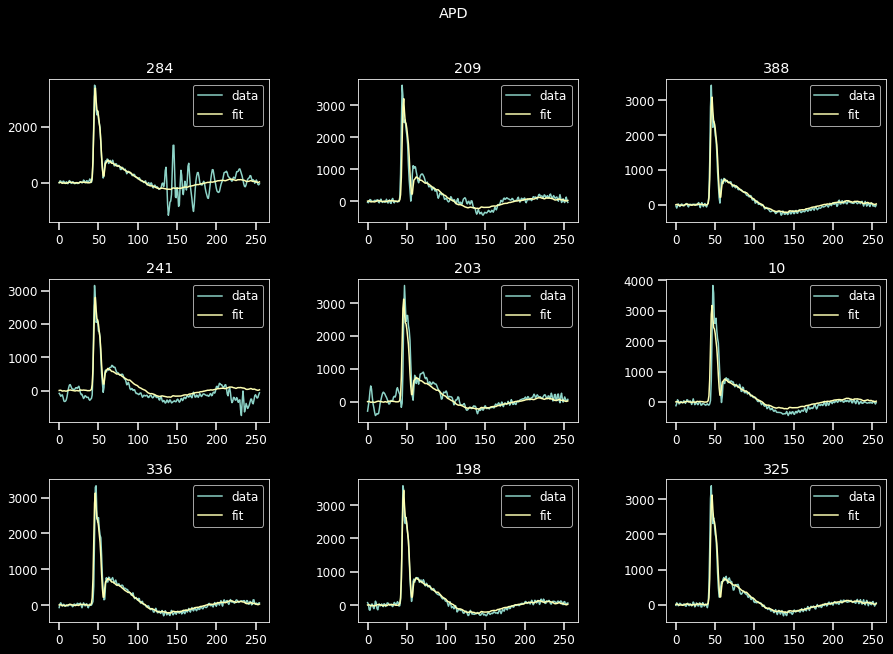

In [31]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('APD')
for ii in range(9):
    idx = np.random.randint(APD.shape[0])
    ax = fig.add_subplot(3,3,ii+1)
    ax.set_title(str(idx))
    ax.plot(APD[idx], label='data')
    ax.plot(APD_regressor.fit_reconstruct(APD[idx]), label='fit')
    ax.legend()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

fig.savefig('./APD_fits.png')

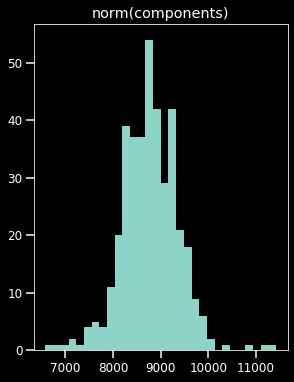

APD standard deviation/mean: 0.06727664656625627


In [40]:
intensity = APD_regressor.get_pulse_intensity(APD)
plt.figure(figsize=(10,6))
ax = plt.subplot(1,2,1)
plt.title('norm(components)')
ax.hist(intensity[:,0], bins=30)
# ax = plt.subplot(1,2,2)
# plt.title('max(fit)')
# ax.hist(intensity[:,1], bins=30)
plt.show()

average = np.mean(intensity)
sigma = np.std(intensity)
print('APD standard deviation/mean:',sigma/average)

### Score

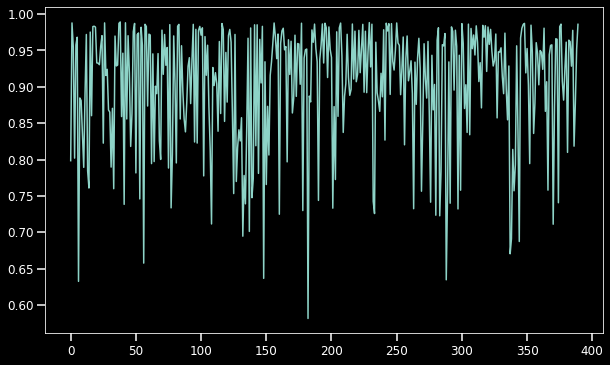

In [37]:
score = []
for apd in APD:
    APD_regressor.fit(apd)
    diode_regressor.fit(apd)
    score.append(APD_regressor.score(apd))
plt.plot(score)

## Slope correction

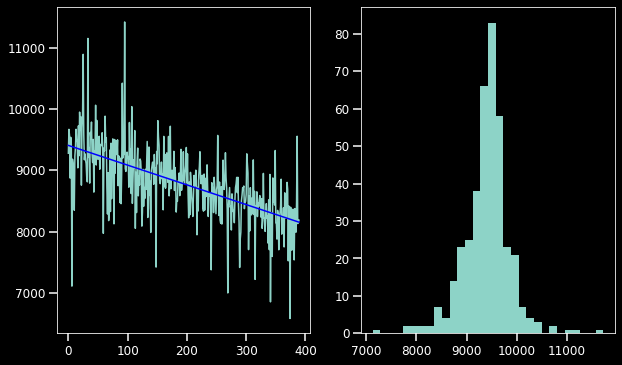

APD standard deviation/mean: 0.04959167381557118


In [38]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,2,1)
ax.plot(intensity)
fit = np.polyfit(np.arange(intensity.shape[0]), intensity[:,0], 1)
fit = np.poly1d(fit)
yfit = fit(np.arange(intensity.shape[0]))
# int_corr = intensity[:,0]-(yfit-np.mean(yfit))
int_corr = intensity[:,0]-(yfit-yfit[0])
ax.plot(yfit, 'b')
ax = plt.subplot(1,2,2)
ax.hist(int_corr, bins=30)
plt.show()
fig.savefig('APD_SN_corr.png')

average = np.mean(int_corr)
sigma = np.std(int_corr)
print('APD standard deviation/mean:',sigma/average)

Floating point -> integer

In [17]:
from sklearn.utils.estimator_checks import check_estimator

In [18]:
reload(proc)
APD_regressor = proc.construct_waveformRegressor(APD[:100], n_components=1)
# check_estimator(proc.WaveformRegressor)
# check_estimator(APD_regressor)